### Esercitazione 19 - OBV (On Balance Volume)
#### Argomenti

* indicatore OBV
* implementazione di una strategia basata su OBV e EMA

On Balance Volume (OBV) è un indicatore che misura la pressione di acquisto e di vendita come indicatore
cumulativo, aggiungendo volume nei giorni in rialzo e sottraendo volume nei giorni in calo.
Quando lo strumento finanziario considerato chiude più in alto della chiusura precedente, tutto il volume
della giornata viene considerato come volume di aumento; al contrario, quando chiude a un livello inferiore
rispetto al precedente, tutto il volume della giornata viene considerato volume negativo.

Calcolo dell'OBV:
Se la chiusura attuale è maggiore della precedente:
OBV = OBV Precedente + Volume attuale

Se la chiusura attuale è minore della precedente:
OBV = OBV precedente – Volume attuale

Se la chiusura attuale e precedente sono uguali:
OBV = OBV precedente

Il valore dell'OBV non è importante quanto la sua direzione e viene spesso utilizzato sfruttando
i segnali generati come descritto di seguito:
* se sia il prezzo che l'OBV stanno raggiungendo picchi e minimi più alti, è probabile che la tendenza al
rialzo continui.
* se sia il prezzo che l'OBV stanno raggiungendo picchi e minimi inferiori, è probabile che la tendenza al
ribasso continui.
* se l'OBV è in aumento in un intervallo di tempo, potrebbe verificarsi un accumulo, un avvertimento di un
breakout al rialzo.
* se l'OBV è in calo in un intervallo di tempo, potrebbe essere in corso una distribuzione, un avvertimento di un breakout al ribasso.  
* se il prezzo continua a raggiungere picchi più elevati mentre l'OBV non riesce ad avere un comportamento
simile, è probabile che la tendenza al rialzo si fermi o fallisca. (*divergenza negativa*)
* se il prezzo continua a raggiungere minimi inferiori e OBV non riesce a raggiungere minimi inferiori,
è probabile che la tendenza al ribasso si arresti o fallisca. (*divergenza positiva*)

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_D1, 0, 1000))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

In [3]:
# utilizziamo Ta-Lib per il calcolo dell'OBV
candles['obv'] = talib.OBV(candles.close, candles.tick_volume)
candles['obv_ema'] = candles['obv'].ewm(com=10).mean()

candles.tail()

,open,high,low,close,tick_volume,spread,real_volume,obv,obv_ema
time,,,,,,,,,
2022-12-05,1.05363,1.05943,1.04798,1.04938,127495,5,0,650489.0,496546.269027
2022-12-06,1.04946,1.05325,1.04588,1.04654,117486,5,0,533003.0,499860.517297
2022-12-07,1.04655,1.05493,1.04427,1.05069,132758,5,0,665761.0,514942.379361
2022-12-08,1.05089,1.05643,1.04889,1.05556,111730,5,0,777491.0,538810.435783
2022-12-09,1.05544,1.05879,1.05461,1.05514,50231,5,0,727260.0,555942.214348


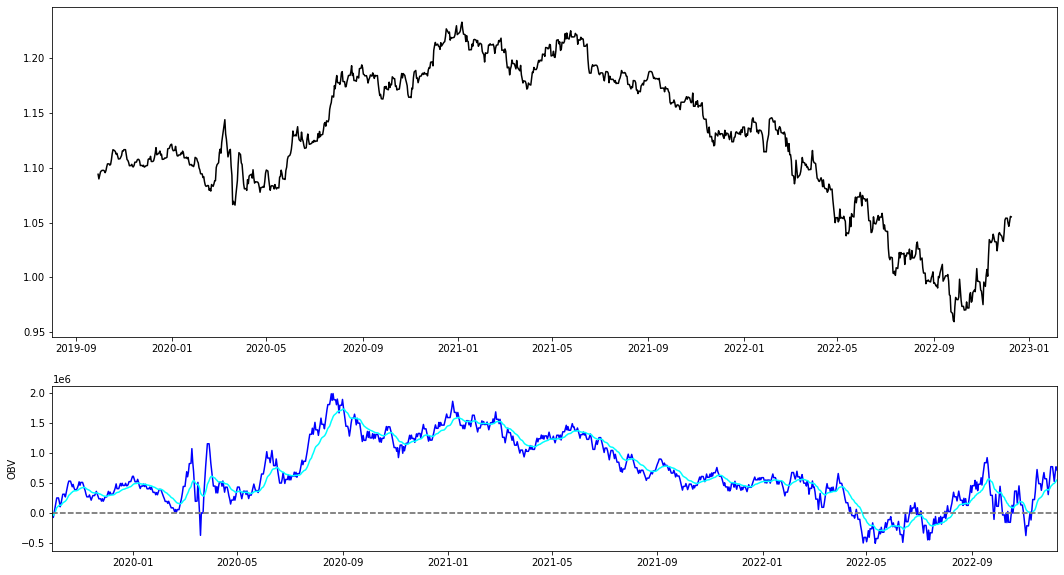

In [4]:
# visualizzazione dell'OBV su un grafico

fig, (ax_price, ax_obv) = plt.subplots(2, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})

ax_price.plot(candles.index, candles['close'], color='black')
plt.autoscale(True, axis='x', tight=True)

ax_obv.plot(candles.index, candles['obv'], color='blue')
ax_obv.plot(candles.index, candles['obv_ema'], color='cyan')
ax_obv.hlines(20, xmin=candles.index[0], xmax=candles.index[-1], color='gray', linestyle='--')
ax_obv.hlines(80, xmin=candles.index[0], xmax=candles.index[-1], color='gray', linestyle='--')
ax_obv.set_ylabel('OBV')

plt.show()

In [5]:
def strategia(dataset):
    buy_op = []
    sell_op = []
    trend = 0
    for i in range(0, len(dataset)):
        if dataset['obv'][i] < dataset['obv_ema'][i] and trend != 1:
            buy_op.append(dataset['close'][i])
            sell_op.append(np.nan)
            trend = 1
        elif dataset['obv'][i] > dataset['obv_ema'][i] and trend != -1:
            sell_op.append(dataset['close'][i])
            buy_op.append(np.nan)
            trend = -1
        else:
            buy_op.append(np.nan)
            sell_op.append(np.nan)

    return buy_op, sell_op

In [6]:
res = strategia(candles)
candles['buy'] = res[0]
candles['sell'] = res[1]

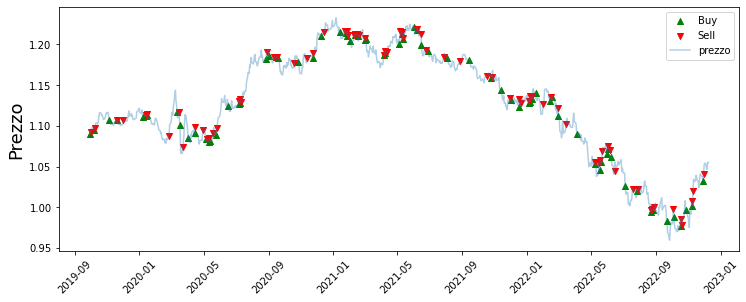

In [7]:
plt.figure(figsize=(12.2, 4.5)) 
plt.scatter(candles.index, candles['buy'], color='green', label='Buy', marker='^', alpha=1)
plt.scatter(candles.index, candles['sell'], color='red', label='Sell', marker='v', alpha=1)
plt.plot(candles['close'], label='prezzo', alpha=0.35)
plt.xticks(rotation=45)
plt.ylabel('Prezzo', fontsize=18)
plt.legend()
plt.show()

In [8]:
posizione = 0
performance = 0.
vinte = 0
perse = 0

for i in range(len(res[0])):
    if not(np.isnan(res[0][i])):
        if posizione == 0:
            posizione = 1
            prezzo_iniziale = candles.iloc[i].close
        elif posizione == -1:
            risultato = prezzo_iniziale - candles.iloc[i].close
            if risultato > 0:
                vinte += 1
            else:
                perse += 1
            performance += risultato
            posizione = 0
    elif not(np.isnan((res[1][i]))):
        if posizione == 0:
            posizione = -1
            prezzo_iniziale = candles.iloc[i].close
        elif posizione == 1:
            risultato = candles.iloc[i].close - prezzo_iniziale
            if risultato > 0:
                vinte += 1
            else:
                perse += 1
            performance += risultato
            posizione = 0

print('performance:', performance, '- vinte', vinte, '/', vinte + perse)

performance: 0.022689999999998656 - vinte 51 / 74
